# Imports

In [1]:
import os

from sklearn.model_selection import train_test_split as split
from torch import save
from torch.cuda import is_available as cuda_available
from torch import device as Device
from torch.backends.mps import is_available as mps_available
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.models.unet import UNet
from src.utils.dataset import ForestDataset
from src.utils.loss import loss
from src.utils.models import train_loop, validation_loop
from src.utils.plots import plot_image_and_prediction
from src.utils.predictions import predict_patch
from src.utils.preprocessing import Preprocessor

# Global parameters

In [2]:
img_dir = "data/images"
patch_dir = "data/patches"
log_dir = "logs"
model_dir = "models"
gedi_file = "data/gedi/gedi_complete.fth"
patches_file = "data/info/patches.fth"
seed = 42
batch_size = 64
num_workers = 6
learning_rate = 1e-4
epochs = 2
device = Device("cuda" if cuda_available() else "mps" if mps_available() else "cpu")
print(f"Using {device} device")

Using mps device


# Preprocess labels and patches

| image | patch | n_labels |
| - | - | - | 
| L15-1059E-1355N	 | 0	 | 28 |

In [3]:
# Create preprocessor
preprocessor = Preprocessor(patches_file, img_dir, patch_dir, gedi_file)

preprocessor.run()

# Extract patches
patches = preprocessor.patches

print(f"Total number of patches: {len(patches)}")

INFO:root:Starting preprocessing...
INFO:root:Directories validated.
INFO:root:Images loaded.
INFO:root:Number of images: 48
INFO:root:Loaded existing patch info file. Skipping image processing.


Total number of patches: 101423


## Create datasets & dataloader

In [4]:
# Split patches
train, rest = split(patches, test_size=0.3, random_state=seed)
val, test = split(rest, test_size=0.5, random_state=seed)

# Create datasets
train_data = ForestDataset(train)
val_data = ForestDataset(val)
test_data = ForestDataset(test)

# Create dataloaders
train_loader = DataLoader(train_data, batch_size, True, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size, False, num_workers=num_workers)
test_loader = DataLoader(val_data, batch_size, False, num_workers=num_workers)

# Create model

In [5]:
# Create model
model = UNet().to(device)

# Create optimizer
optimizer = Adam(model.parameters(), learning_rate)

# Create writer
writer = SummaryWriter(log_dir)

# Train model

In [6]:
# Training loop
for epoch in range(epochs):
    train_loop(train_loader, model, loss, writer, device, epoch, optimizer)
    validation_loop(val_loader, model, loss, writer, device, epoch)

writer.close()

print("Training complete.")

Training Epoch 1:   0%|          | 0/1110 [00:00<?, ?it/s]/Users/ematala/dev/tree-heights-germany/.venv/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Validation Epoch 2: 100%|██████████| 238/238 [01:05<00:00,  3.64it/s]

Training complete.


# Export model

In [7]:
save(model.state_dict(), os.path.join(model_dir, "unet.pt"))

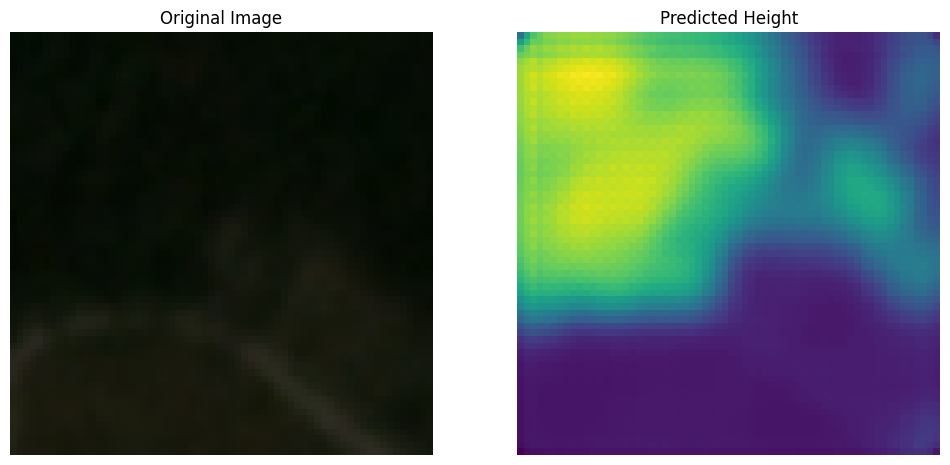

In [20]:
idx = 3
patch = test_data[idx]
image, prediction = predict_patch(model, patch, device)
plot_image_and_prediction(image, prediction)